In [1]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
import calfem.vis_mpl as cfvl
import numpy as np

### Define Geometry

In [2]:
g = cfg.Geometry()

g.point([0.0, 0.0]) # point 0
g.point([4.0, 0.0]) # point 1
g.point([4.0, 2.0]) # point 2
g.point([0.0, 2.0]) # point 2

g.spline([0, 1], marker=0) # line 0
g.spline([1, 2], marker=1) # line 1
g.spline([2, 3], marker=0) # line 2
g.spline([3, 0], marker=1) # line 3

g.surface([0, 1, 2, 3])


### Generate Mesh

In [3]:
def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset)-1)
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem-1] = key
    return new

In [37]:
mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.1 # Element size Factor
coords, edof, dofs, bdofs, elementmarkers = mesh.create()


    
boundary_voltages = reshape_boundary_dict(bdofs)

flag = True
flag1 = True
count = 0
ind = len(boundary_voltages) 
ind_n = 0

for k in range(len(boundary_voltages)):
    i = len(boundary_voltages) - 1 - k
    if boundary_voltages[i] == 1.:
        ind_n = i
        boundary_voltages[i] = 0.
        if abs(ind_n - ind)!= 1:
            break
        ind = i
    else:
        boundary_voltages[i] = 10.
        count += 1

for k in range(len(boundary_voltages)):
    i = len(boundary_voltages) - 1 - k
    if boundary_voltages[i] == 1.:        
        boundary_voltages[i] = 0.
    
    
        

    

print(boundary_voltages)
print(count)
# print(bdofs)

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmp4tv953ax/tempGeometry.geo'...
Info    : Done reading '/tmp/tmp4tv953ax/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.00070896s, CPU 0.000769s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0268955s, CPU 0.027142s)
Info    : 998 nodes 1998 elements
Info    : Writing '/tmp/tmp4tv953ax/meshFile.msh'...
Info    : Done writing '/tmp/tmp4tv953ax/meshFile.msh'
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 

### Assemble Element Matrices

In [5]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2  + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix([[M11, M12, M13],
                      [M12, M22, M23],
                      [M13, M23, M33]])

In [69]:
import pandas as pd
df_x_y = pd.read_csv("./domains/domain_2/mesh005_test/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh005_test/Test_domain_2_rectangle_dirichlet_only_005_test_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh005_test/mesh_polygons.csv")
co = coords.copy()
for i in range(len(df_x_y["x"].values)):
    co[i][0] = df_x_y["x"].values[i]
    co[i][1] = df_x_y["y"].values[i]

num_elem = len(edof)
num_nodes = len(dofs)

ke = np.zeros((num_elem, 3, 3))

for i in range(num_elem):
    ke[i] = Ke(co[edof[i] - 1], 1, 1)

print(ke[40])

[[-0.46389838  0.078461    0.38543738]
 [ 0.078461   -0.55218155  0.47372055]
 [ 0.38543738  0.47372055 -0.85915793]]


### Assemble Global Matrix

In [41]:
K = np.zeros((num_nodes, num_nodes))
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e,i] - 1, edof[e,j] - 1] += ke[e,i,j]

### Create RHS Vector

In [42]:
b = np.zeros(num_nodes)

### Introduce Boundary Conditions

In [43]:
for n in reversed (range(len(boundary_voltages))):
    for i in range(len(b)):
        b[i] -= boundary_voltages[n]*K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)

### Solve

In [49]:
x = np.linalg.solve(K,b)
v = np.zeros(num_nodes-len(x))
v = np.concatenate((boundary_voltages,x))

### Plot

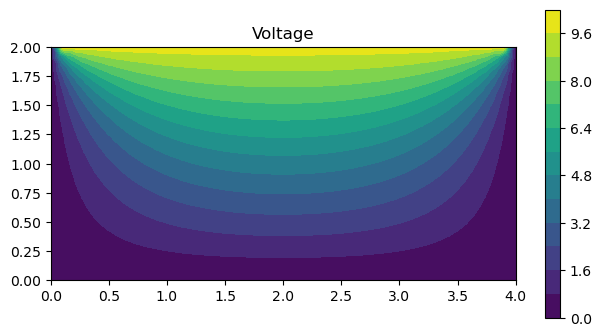

In [50]:
cfvl.figure(fig_size=(7.5, 4))
cfvl.draw_nodal_values_contourf(v, coords, edof, title="Voltage", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=False)
cfvl.colorbar()

0.0, 0.0
4.0, 0.0
4.0, 2.0
0.0, 2.0
0.1000000000855615, 0.0
0.2000000001571211, 0.0
0.3000000002525331, 0.0
0.4000000003750502, 0.0
0.5000000005040726, 0.0
0.6000000006092424, 0.0
0.7000000007469384, 0.0
0.8000000008304242, 0.0
0.9000000009594464, 0.0
1.000000001170868, 0.0
1.100000001538415, 0.0
1.200000001836573, 0.0
1.300000002043658, 0.0
1.400000002463247, 0.0
1.500000002639974, 0.0
1.600000002903437, 0.0
1.700000002819955, 0.0
1.800000003209186, 0.0
1.900000003489997, 0.0
2.000000003762134, 0.0
2.100000003318697, 0.0
2.200000003198353, 0.0
2.300000002837316, 0.0
2.400000002506636, 0.0
2.500000001967791, 0.0
2.600000001415933, 0.0
2.700000000608206, 0.0
2.8000000002038, 0.0
2.899999999964193, 0.0
2.999999999663872, 0.0
3.099999999250793, 0.0
3.199999999132618, 0.0
3.299999998741223, 0.0
3.399999999212854, 0.0
3.49999999926815, 0.0
3.599999999132627, 0.0
3.699999999326702, 0.0
3.799999999555472, 0.0
3.899999999996744, 0.0
4.0, 0.1000000000791027
4.0, 0.2000000001886094
4.0, 0.300000

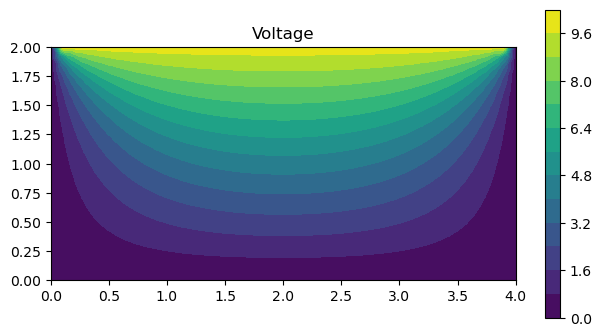

In [70]:
import pandas as pd
df_x_y = pd.read_csv("./domains/domain_2/mesh005_test/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh005_test/Test_domain_2_rectangle_dirichlet_only_005_test_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh005_test/mesh_polygons.csv")
# for element in df_elements.values:
#     element -= 1;

co = coords.copy()
for i in range(len(df_x_y["x"].values)):
    co[i][0] = df_x_y["x"].values[i]
    co[i][1] = df_x_y["y"].values[i]

for k in co:
    print(f"{k[0]}, {k[1]}")

cfvl.figure(fig_size=(7.5, 4))
cfvl.draw_nodal_values_contourf(df_z["sol"].values, co, df_elements.values, title="Voltage", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=False)
cfvl.colorbar()


In [71]:
print(len(v))
print(len(coords))
print(len(edof))

from numba import njit

@njit()
def exact_solution(x, y, row_num_el: int = 50):
    res = 0
    for n in range(1, row_num_el + 1):
        res += 20 * (1 - (-1) ** n) / (np.pi * n) / (np.exp(- np.pi * n / 2 ) - np.exp( np.pi * n / 2 )) * (np.exp(- np.pi * n / 4 * y ) - np.exp( np.pi * n / 4 * y)) * np.sin(np.pi * n / 4 * x)
    if res > 10.:
        res = 10.
    return res

def print_mean_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        error_in_node.append( np.fabs( z[i] - exact_solution(x[i], y[i]) ))
    print("Mean error: ", round(np.mean(error_in_node), 8))
    print("Max error: ", round(np.max(error_in_node), 8))

    # for i in range(len(error_in_node)):
    #     if error_in_node[i] > 0.2:
    #         print( x[i], y[i], error_in_node[i])



998
998
1874


In [72]:
x = []
y = []
for i in range(len(coords)):
    x.append(coords[i][0])
    y.append(coords[i][1])


In [73]:
print_mean_error(x, y, v)

Mean error:  0.00777009
Max error:  0.61644325
